In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from IPython.display import display

In [2]:
df = pd.read_excel('Case_data.xlsx')

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None
df.head(5)

,dayssincefirst,dayssincelast,PurchaseMen,Purchasekids,Purchasesports,Purchaseswim,Purchaseeco,Purchasejackets,zipcode,sharehighfashion,purchaseonline,purchlast1year,purchlast2years,age,clubmember,emailsubscriber,salesdriven,purchasepostcard
0,2036,799,No,No,Yes,Yes,No,Yes,130,.,.,0,129.93,46,1,.,No,No
1,2073,397,No,No,Yes,Yes,No,Yes,730,.,1,92.94,506.69,46,1,.,No,No
2,1518,379,No,No,Yes,Yes,No,Yes,68300,.,1,263.91,263.91,48,0,1,No,No
3,1935,587,No,No,Yes,Yes,No,Yes,74700,.,.,0,192.93,63,0,.,No,No
4,1888,947,No,No,Yes,Yes,No,Yes,1700,.,.,0,89.96,48,0,.,No,No


In [ ]:
display(df.shape)

display(df.isnull().any())

display(df.dtypes)

display(df.describe())

In [ ]:
df['purchasepostcard'].hist()

In [ ]:
df['purchlast1year'].hist()

In [ ]:
np.log(df['purchlast1year']+1).hist()

In [ ]:
df['dayssincelast'].hist()

In [ ]:
df['dayssincefirst'].hist()

In [4]:
df.columns

Index(['dayssincefirst', 'dayssincelast', 'PurchaseMen', 'Purchasekids',
       'Purchasesports', 'Purchaseswim', 'Purchaseeco', 'Purchasejackets',
       'zipcode', 'sharehighfashion', 'purchaseonline', 'purchlast1year',
       'purchlast2years', 'age', 'clubmember', 'emailsubscriber',
       'salesdriven', 'purchasepostcard'],
      dtype='object')

### Data cleansing

In [5]:
df = df.replace(".", 0)

In [6]:
df.purchasepostcard = df.purchasepostcard.replace(to_replace=['No', 'Yes'], value=[0, 1])

In [7]:
df['clubmember'] = df.clubmember.replace(to_replace=[0, 1], value=['No', 'Yes'])
df['emailsubscriber'] = df.emailsubscriber.replace(to_replace=[0, 1], value=['No', 'Yes'])
df['purchaseonline'] = df.purchaseonline.replace(to_replace=[0, 1], value=['No', 'Yes'])
df['zipcode'] = df['zipcode'].astype(str)

In [8]:
df.head()

,dayssincefirst,dayssincelast,PurchaseMen,Purchasekids,Purchasesports,Purchaseswim,Purchaseeco,Purchasejackets,zipcode,sharehighfashion,purchaseonline,purchlast1year,purchlast2years,age,clubmember,emailsubscriber,salesdriven,purchasepostcard
0,2036,799,No,No,Yes,Yes,No,Yes,130,0,No,0,129.93,46,Yes,No,No,0
1,2073,397,No,No,Yes,Yes,No,Yes,730,0,Yes,92.94,506.69,46,Yes,No,No,0
2,1518,379,No,No,Yes,Yes,No,Yes,68300,0,Yes,263.91,263.91,48,No,Yes,No,0
3,1935,587,No,No,Yes,Yes,No,Yes,74700,0,No,0,192.93,63,No,No,No,0
4,1888,947,No,No,Yes,Yes,No,Yes,1700,0,No,0,89.96,48,No,No,No,0


In [9]:
num_features = ['dayssincefirst', 'dayssincelast', 'purchlast2years', 'purchlast1year', 'sharehighfashion']
for feat in num_features:
    df[feat] = pd.to_numeric(df[feat])

### Feature Engineering

In [10]:
df['purchase2ndyear'] = df['purchlast2years'] - df['purchlast1year']

In [11]:
df['last1year/last2ndyear'] = df.purchlast1year/(df.purchase2ndyear+0.01)*100

In [12]:
bins = [0, 25, 35, 45, 55, 65, np.inf]
names = ['<25', '25-35', '35-45', '45-55', '55-65', '65+']

df['age_range'] = pd.cut(df['age'], bins, labels=names)

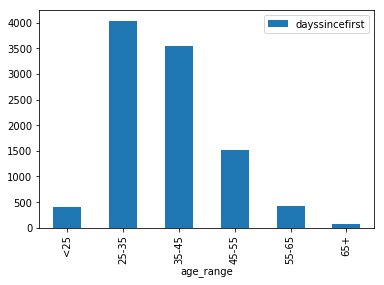

In [13]:
df.groupby('age_range').count()[['dayssincefirst']].plot.bar()

In [14]:
features = df.drop(['purchasepostcard'],1)

In [15]:
features.columns

Index(['dayssincefirst', 'dayssincelast', 'PurchaseMen', 'Purchasekids',
       'Purchasesports', 'Purchaseswim', 'Purchaseeco', 'Purchasejackets',
       'zipcode', 'sharehighfashion', 'purchaseonline', 'purchlast1year',
       'purchlast2years', 'age', 'clubmember', 'emailsubscriber',
       'salesdriven', 'purchase2ndyear', 'last1year/last2ndyear', 'age_range'],
      dtype='object')

In [16]:
features_cat = ['PurchaseMen', 'Purchasekids', 'Purchasesports', 'Purchaseswim', 'Purchaseeco', 'Purchasejackets',
               'zipcode', 'purchaseonline', 'clubmember', 'emailsubscriber', 'salesdriven', 'age_range']
num_features.extend(['purchase2ndyear', 'last1year/last2ndyear'])

In [17]:
X_cat = pd.get_dummies(features[features_cat], prefix=features_cat)

In [18]:
data_features_num = df[num_features]
X = pd.concat([X_cat, data_features_num], axis=1)

In [19]:
X.head()

PurchaseMen_No  PurchaseMen_Yes  Purchasekids_No  Purchasekids_Yes  \
0               1                0                1                 0   
1               1                0                1                 0   
2               1                0                1                 0   
3               1                0                1                 0   
4               1                0                1                 0   

   Purchasesports_No  Purchasesports_Yes  Purchaseswim_No  Purchaseswim_Yes  \
0                  0                   1                0                 1   
1                  0                   1                0                 1   
2                  0                   1                0                 1   
3                  0                   1                0                 1   
4                  0                   1                0                 1   

   Purchaseeco_No  Purchaseeco_Yes  Purchasejackets_No  Purchasejackets_Yes  \
0               1                0                   0                    1   
1               1                0                   0                    1   
2               1                0                   0                    1   
3               1                0                   0                    1   
4               1                0                   0                    1   

   zipcode_100  zipcode_10120  zipcode_10160  zipcode_10210  zipcode_10300  \
0            0              0              0              0              0   
1            0              0              0              0              0   
2            0              0              0              0              0   
3            0              0              0              0              0   
4            0              0              0              0              0   

   zipcode_10320  zipcode_10330  zipcode_10360  zipcode_10420  zipcode_10520  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   zipcode_10600  zipcode_10620  zipcode_10640  zipcode_10650  zipcode_10660  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   zipcode_10710  zipcode_10820  zipcode_10900  zipcode_10940  zipcode_10960  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              0              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   zipcode_11100  zipcode_11120  zipcode_11130  zipcode_1120  zipcode_11310  \
0              0              0              0             0              0   
1              0              0              0             0              0   
2              0              0              0             0              0   
3              0              0              0             0              0   
4              0              0              0             0              0   

   zipcode_1150  zipcode_11710  zipcode_11910  zipcode_120  zipcode_1200  \
0             0              0              0            0             0   
1             0              0              0            0             0   

In [20]:
X.shape

(10000, 1753)

In [21]:
y = df['purchasepostcard']

In [22]:
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    print("Training length: " +str(len(y_train)))
    print("Test length: " +str(len(y_test)))
    
    return X_train, X_test, y_train, y_test

In [23]:
X_train, X_test, y_train, y_test = split_data(X, y)

Training length: 7000
Test length: 3000


### Building the model!

In [63]:
rf_clf = RandomForestClassifier(n_estimators=200, #min_samples_leaf=5, max_features=5, 
                                class_weight="balanced", 
                                n_jobs=-1, oob_score=True, verbose=True, random_state=0)

In [64]:
rf_clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    4.0s finished


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=True, random_state=0,
            verbose=True, warm_start=False)

In [65]:
rf_clf.score(X_test, y_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished


0.932

In [67]:
y_test_pred = rf_clf.predict(X_test)
y_pred_pb = rf_clf.predict_proba(X_test)[:, 1]

def plot_roc_curve(y_test, y_pred_pb):
    fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_pb)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf, label='RF')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

    print('Roc_auc Score: {:.3f} \nPrecison Score:{:.3f} \nRecall Score:{:.3f} \nF1 Score ("1" class):{:.3f}'
          .format(roc_auc_score(y_test, y_test_pred),
                 precision_score(y_test, y_test_pred),
                 recall_score(y_test, y_test_pred),
                 f1_score(y_test, y_test_pred)))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


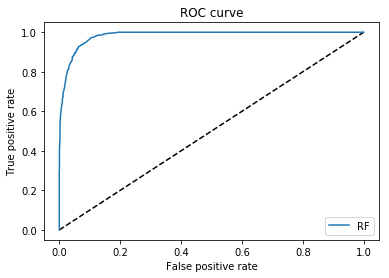

Roc_auc Score: 0.917 
Precison Score:0.892 
Recall Score:0.878 
F1 Score ("1" class):0.885


In [68]:
plot_roc_curve(y_test, y_pred_pb)

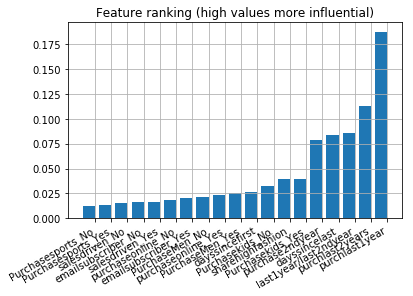

In [69]:
X_names = X_cat.columns.tolist()
X_names.extend(num_features)

imp = rf_clf.feature_importances_
sortNames = [y for (x,y) in sorted(zip(imp,X_names)) if x>0.01]
sortImp = [x for (x,y) in sorted(zip(imp,X_names)) if x>0.01]

fig = plt.figure()
ind = np.arange(len(sortImp))
width = .75
plt.bar(ind, sortImp, width=width)
plt.xticks(ind + width / 2, sortNames)
fig.autofmt_xdate()
plt.grid(True)
plt.title('Feature ranking (high values more influential)')
plt.show()

## Customer segmentation

Recency, Frequency and Monetary model

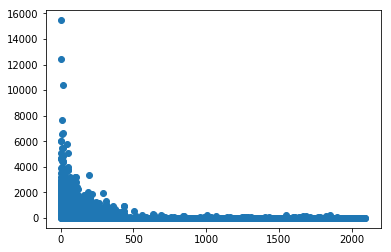

In [30]:
plt.scatter(df['dayssincelast'], df['purchlast1year'])

We can segment the customers from this distribution to 3 kinds: very recent and spend a lot, not recent and spend little, and everything in between.

In [31]:
rfm = ['dayssincelast', 'purchlast1year', 'purchase2ndyear', 'dayssincefirst']
scaler = preprocessing.StandardScaler
X_cleaned = scaler().fit_transform(df.loc[:,rfm].values)

In [32]:
X_cleaned = pd.DataFrame(data=X_cleaned, columns=rfm)

In [33]:
X_cleaned.head()

,dayssincelast,purchlast1year,purchase2ndyear,dayssincefirst
0,0.622843,-0.519889,-0.415998,0.614355
1,-0.158374,-0.351426,-0.025766,0.701367
2,-0.193354,-0.041526,-0.594641,-0.603806
3,0.210858,-0.519889,-0.329377,0.376837
4,0.910455,-0.519889,-0.470953,0.266309


Text(0,0.5,'wcss: sum of dist. of sample to their closest cluster center')

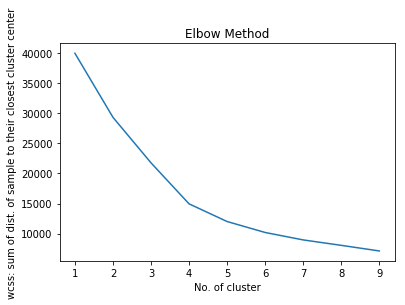

In [34]:
wcss=[]
for i in range(1,10):
    kmeans=KMeans(n_clusters=i,init='k-means++',)
    kmeans.fit(X_cleaned)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,10),wcss)
plt.title('Elbow Method')
plt.xlabel('No. of cluster')
plt.ylabel('wcss: sum of dist. of sample to their closest cluster center' )

In [35]:
kmeans_1=KMeans(n_clusters=4)
kmeans_1.fit(X_cleaned)
cluster_pred=kmeans_1.predict(X_cleaned)
cluster_pred_2=kmeans_1.labels_
cluster_center=kmeans_1.cluster_centers_

In [36]:
pca = PCA(n_components = 2, random_state = 0)
pca.fit(X_cleaned)

# Transform the good data using the PCA fit above
reduced_data = pca.transform(X_cleaned)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])


In [37]:
def biplot(good_data, reduced_data, pca):

    fig, ax = plt.subplots(figsize = (14,8))
    # scatterplot of the reduced data    
    ax.scatter(x=reduced_data.loc[:, 'Dimension 1'], y=reduced_data.loc[:, 'Dimension 2'], 
        facecolors='b', edgecolors='b', s=70, alpha=0.5)
    
    feature_vectors = pca.components_.T

    # we use scaling factors to make the arrows easier to see
    arrow_size, text_pos = 70.0, 8.0,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], 
                  head_width=0.2, head_length=2, linewidth=2, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, good_data.columns[i], color='black', 
                 ha='center', va='center', fontsize=18)

    ax.set_xlabel("Dimension 1", fontsize=14)
    ax.set_ylabel("Dimension 2", fontsize=14)
    ax.set_title("PC plane with original feature projections.", fontsize=16);
    return ax

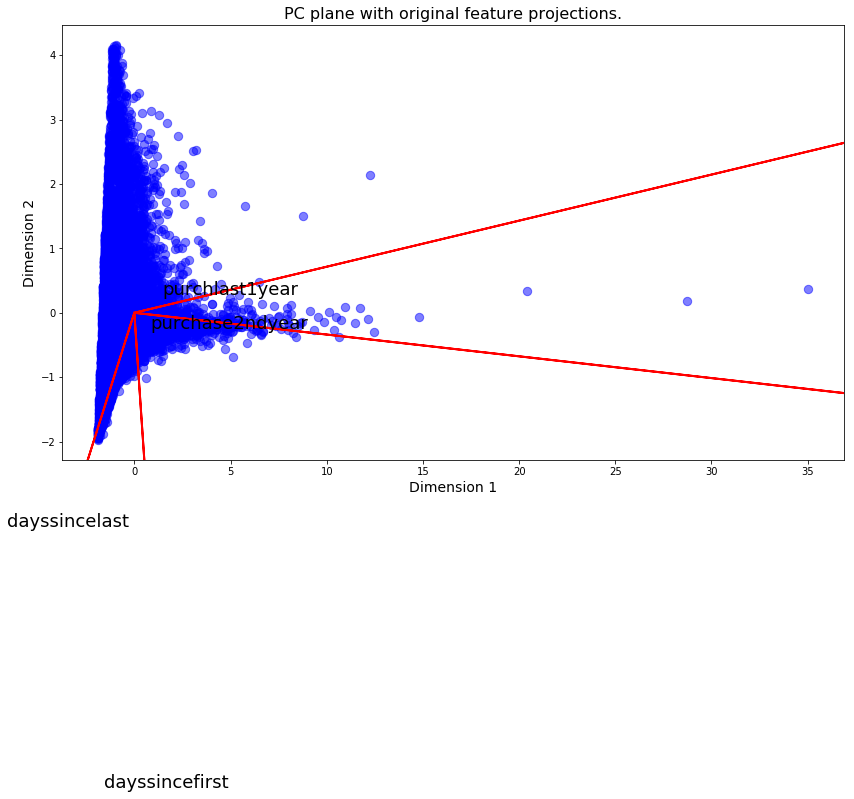

In [38]:
clusterer = KMeans(n_clusters = 4)
clusterer.fit(reduced_data)
preds = clusterer.predict(reduced_data)
centers = clusterer.cluster_centers_


biplot(X_cleaned, reduced_data, pca)

In [40]:
def cluster_results(reduced_data, preds, centers):

    predictions = pd.DataFrame(preds, columns = ['Cluster'])
    plot_data = pd.concat([predictions, reduced_data], axis = 1)

    # Generate the cluster plot
    fig, ax = plt.subplots(figsize = (14,8))

    # Color map
    cmap = cm.get_cmap('gist_rainbow')

    # Color the points based on assigned cluster
    for i, cluster in plot_data.groupby('Cluster'):   
        cluster.plot(ax = ax, kind = 'scatter', x = 'Dimension 1', y = 'Dimension 2', \
                    color = cmap((i)*1.0/(len(centers)-1)), label = 'Cluster %i'%(i), s=30);

    # Plot centers with indicators
    for i, c in enumerate(centers):
        ax.scatter(x = c[0], y = c[1], color = 'white', edgecolors = 'black', \
                   alpha = 1, linewidth = 2, marker = 'o', s=200);
        ax.scatter(x = c[0], y = c[1], marker='$%d$'%(i), alpha = 1, s=100);

    ax.set_title("Cluster Learning on PCA-Reduced Data - Centroids Marked by Number\nTransformed Sample Data Marked by Black Cross");


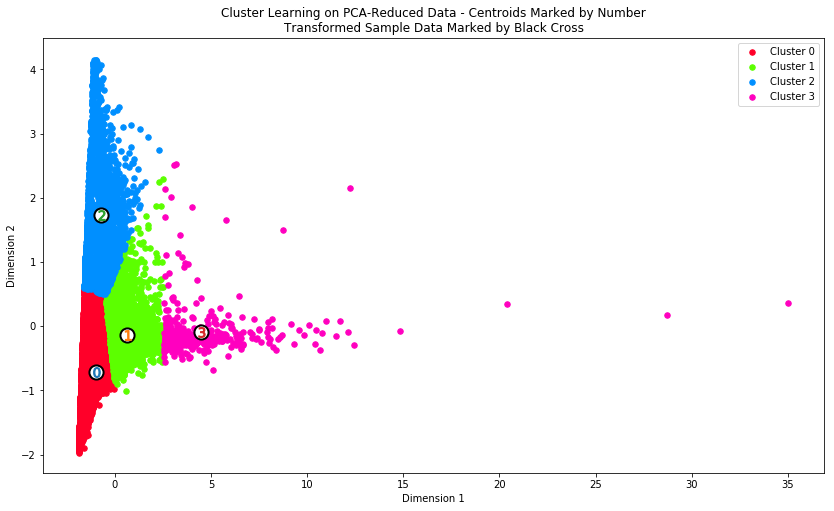

In [41]:
cluster_results(reduced_data, preds, centers)

In [42]:
predictions = pd.DataFrame(preds, columns = ['Cluster'])
plot_data = pd.concat([predictions, reduced_data, df[rfm]], axis = 1)

In [44]:
plot_data.head(10)

,Cluster,Dimension 1,Dimension 2,dayssincelast,purchlast1year,purchase2ndyear,dayssincefirst
0,0,-0.722165,-0.827843,799,0.00,129.93,2036
1,1,-0.021757,-0.591070,397,92.94,413.75,2073
2,2,-0.436132,0.640130,379,263.91,0.00,1518
3,0,-0.540728,-0.445775,587,0.00,192.93,1935
4,0,-0.951901,-0.625670,947,0.00,89.96,1888
5,1,1.197879,-0.286982,2,284.76,1204.21,2073
6,1,-0.009519,-0.533340,279,129.93,251.81,2093
7,0,-1.720365,-0.572404,1618,0.00,0.00,1618
8,1,1.250732,-0.327677,183,948.28,570.66,2059
9,2,-1.122324,4.096850,28,39.99,0.00,28


From the above we can derive what each cluster means.

## New customers

In [ ]:
df['purchlast1year'].hist(bins=20)

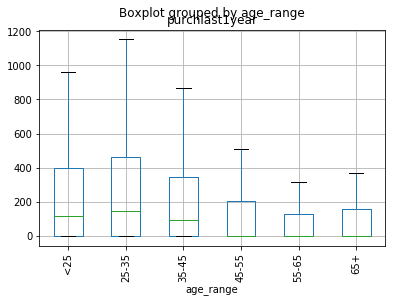

In [45]:
fig, ax = plt.subplots()
box = df.boxplot(column='purchlast1year', by='age_range', figsize=(10, 5), rot=90, ax=ax, sym='')
ax.margins(y=0.05)
plt.show()
#df.groupby(['age_range']).mean()[['purchlast1year']].plot.barh()

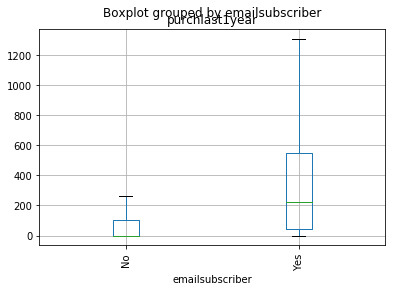

In [46]:
fig, ax = plt.subplots()
box = df.boxplot(column='purchlast1year', by='emailsubscriber', figsize=(10, 5), rot=90, ax=ax, sym='')
ax.margins(y=0.05)
plt.show()
#df.groupby(['emailsubscriber']).mean()['purchlast1year'].plot.barh()

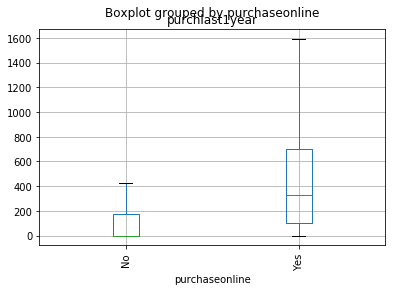

In [47]:
fig, ax = plt.subplots()
box = df.boxplot(column='purchlast1year', by='purchaseonline', figsize=(10, 5), rot=90, ax=ax, sym='')
ax.margins(y=0.05)
plt.show()
#df.groupby(['purchaseonline']).mean()['purchlast1year'].plot.barh()

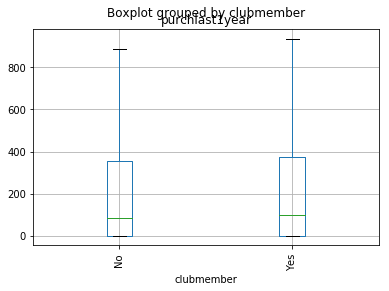

In [48]:
fig, ax = plt.subplots()
box = df.boxplot(column='purchlast1year', by='clubmember', figsize=(10, 5), rot=90, ax=ax, sym='')
ax.margins(y=0.05)
plt.show()
#df.groupby(['clubmember']).mean()['purchlast1year'].plot.barh()

### Bonus: predicting last 1 year purchase amount

In [49]:
features_rgr = features[['dayssincefirst', 'sharehighfashion','purchase2ndyear', 'purchaseonline',
                       'clubmember', 'emailsubscriber', 'salesdriven', 'age_range']]
y_rgr = features['purchlast1year']

In [50]:
features_rgr.head()

,dayssincefirst,sharehighfashion,purchase2ndyear,purchaseonline,clubmember,emailsubscriber,salesdriven,age_range
0,2036,0.0,129.93,No,Yes,No,No,45-55
1,2073,0.0,413.75,Yes,Yes,No,No,45-55
2,1518,0.0,0.00,Yes,No,Yes,No,45-55
3,1935,0.0,192.93,No,No,No,No,55-65
4,1888,0.0,89.96,No,No,No,No,45-55


In [51]:
X_rgr = pd.get_dummies(features_rgr)

In [52]:
X_rgr_train, X_rgr_test, y_rgr_train, y_rgr_test = split_data(X_rgr, y_rgr)

Training length: 7000
Test length: 3000


In [53]:
rf_rgr = RandomForestRegressor(n_estimators=200, min_samples_leaf=5, max_features=4,  
                                n_jobs=-1, oob_score=True, verbose=True, random_state=0)

In [54]:
rf_rgr.fit(X_rgr_train, y_rgr_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=True, random_state=0,
           verbose=True, warm_start=False)

In [55]:
rf_rgr.score(X_rgr_test, y_rgr_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


0.6247006790200798

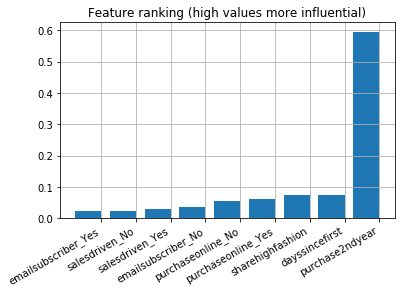

In [56]:
X_names = X_rgr.columns

imp = rf_rgr.feature_importances_
sortNames = [y for (x,y) in sorted(zip(imp,X_names)) if x>0.01]
sortImp = [x for (x,y) in sorted(zip(imp,X_names)) if x>0.01]

fig = plt.figure()
ind = np.arange(len(sortImp))
width = .75
plt.bar(ind, sortImp, width=width)
plt.xticks(ind + width / 2, sortNames)
fig.autofmt_xdate()
plt.grid(True)
plt.title('Feature ranking (high values more influential)')
plt.show()